In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
to_pedix = str.maketrans("3", "₃")

In [3]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

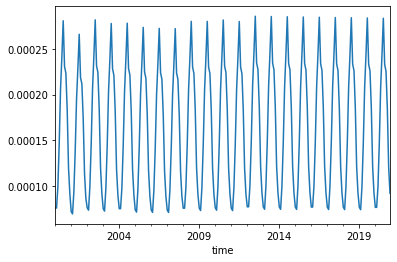

In [4]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')

nh3.plot()
plt.show()

In [5]:
from math import pi
import pandas as pd
import numpy as np

def harmonic(t, order, seasonality):
    return np.sin(np.multiply(t, order*2*pi/seasonality)), np.cos(np.multiply(t, order*2*pi/seasonality))

def create_harmonic_regressors(df, order, seasonality):
      
    for i in range(order):
        sin_t, cos_t = harmonic(df['t'], order=order, seasonality=seasonality)
        if i > 0:
            sin_name = 'sin({}t)'.format(i+1)
            cos_name = 'cos({}t)'.format(i+1)
        else:
            sin_name = 'sin(t)'
            cos_name = 'cos(t)'

        df[sin_name] = sin_t
        df[cos_name] = cos_t

    return df

In [6]:
nh3 = pd.Series(nh3)

t = [i for i in range(len(nh3))]

df = pd.DataFrame({'ts': nh3, 't': t})

train_data, test_data = utils.ts_train_test_split(df, .8)

In [7]:
import random

random.seed(0)

def random_training_validation_window(df, size, validation_size):

    n = len(df)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return df[start:end], df[end:end+validation_size]

In [8]:
train_data, test_data = utils.ts_train_test_split(df, .8)

In [9]:
def multiple_forecasts(model, df, exog_columns, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(times):
        prediction = model.forecast(exog=df[exog_columns][:1])
        model = model.append([prediction.values[0]], refit=refit, exog=df[exog_columns][i:i+1])
        predictions.append(prediction.values[0])
        errors.append(df['ts'].values[i] - prediction.values[0])
    
    return predictions, errors

In [10]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

def random_cross_validation(df, order, seasonal_order, harmonic_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    resid_acfs = []

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(df, train_months/len(df), validation_months)

        df_exog_train = create_harmonic_regressors(train_data, harmonic_order, 12)
        df_exog_validation = create_harmonic_regressors(validation_data, harmonic_order, 12)

        exog_columns = list(df.columns)[2:]

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data['ts'], exog=train_data[exog_columns], order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aic)
        bics.append(model.bic)

        # prediction out of sample
        predictions, errors = multiple_forecasts(model=model, df=validation_data, exog_columns=exog_columns, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data['ts'].values) ** 2)))
        rmses.append(rmse)

        resid_acf = np.mean(np.abs(acf(model.resid, nlags=24)))
        resid_acfs.append(resid_acf)

    return np.mean(aics), np.mean(bics), np.mean(rmses), np.mean(resid_acfs)

In [12]:
def model_selection(df, cv_iterations=1, verbose=False):
    
    p_list = [1, 2, 3, 4]
    q_list = [0, 1]
    P_list = [0, 1]
    Q_list = [0]
    harmonic_orders = [1,2,3,4,5,6]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for h in harmonic_orders:
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={}) with harmonic order {}'.format(p, q, P, Q, 12, h)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        aic, bic, rmse, resid_acf = random_cross_validation(df=df, order=(p,0,q), seasonal_order=(P,0,Q,12), harmonic_order=h, times=cv_iterations)

                        results[model_name] = {
                            'index' : model_idx,
                            'harmonic_order': h,
                            'order' : (p,0,q),
                            'seasonal_order' : (P,0,Q,12),
                            'aic' : aic,
                            'bic' : bic,
                            'rmse' : rmse,
                            'acf': resid_acf
                            }

                        idx += 1
                    
                    
    return results

In [13]:
results = model_selection(train_data, cv_iterations=5, verbose=True)

0: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12) with harmonic order 1
1: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12) with harmonic order 2
2: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12) with harmonic order 3
3: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12) with harmonic order 4
4: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12) with harmonic order 5
5: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12) with harmonic order 6
6: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12) with harmonic order 1
7: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12) with harmonic order 2
8: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12) with harmonic order 3
9: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12) with harmonic order 4
10: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12) with harmonic order 5
11: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12) with harmonic order 6
12: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=0, s=12) with harmonic order 1
13: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=0, s=12) with harmonic order 2
14: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=0, s=1

In [14]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
acfs = [v['acf'] for k, v in results.items()]

In [15]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

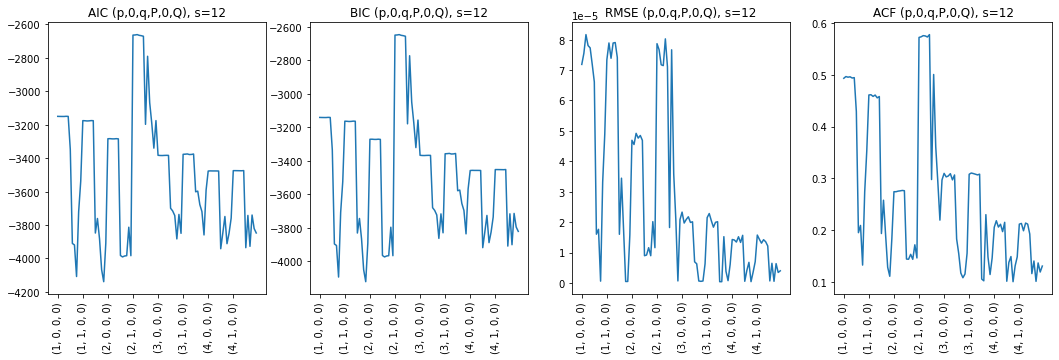

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
indices = np.arange(0, len(results), 12)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[3].plot(acfs)
axs[3].set_title('ACF (p,0,q,P,0,Q), s=12')
axs[3].set_xticks(indices)
axs[3].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [17]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'index': 22,
 'harmonic_order': 5,
 'order': (1, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4138.721261936323,
 'bic': -4122.756477681872,
 'rmse': 4.864496044422404e-07,
 'acf': 0.11122066574951908}

In [18]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'index': 22,
 'harmonic_order': 5,
 'order': (1, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4138.721261936323,
 'bic': -4122.756477681872,
 'rmse': 4.864496044422404e-07,
 'acf': 0.11122066574951908}

In [19]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'index': 66,
 'harmonic_order': 1,
 'order': (3, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3601.2257412691715,
 'bic': -3578.87504331294,
 'rmse': 4.1143403810023863e-07,
 'acf': 0.10591397561219762}

In [20]:
min_acf_model = [v for k,v in results.items() if v['acf'] == np.min(acfs)][0]
min_acf_model

{'index': 81,
 'harmonic_order': 4,
 'order': (4, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3911.5215970514773,
 'bic': -3889.1708990952457,
 'rmse': 4.293992639568905e-07,
 'acf': 0.10075767122050157}

In [21]:
df_train = create_harmonic_regressors(train_data, min_aic_model['harmonic_order'], 12)
df_test = create_harmonic_regressors(test_data, min_aic_model['harmonic_order'], 12)

exog_columns = list(df_train.columns)[2:]

model = ARIMA(endog=df_train['ts'], exog=df_train[exog_columns], order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order'], ).fit()

In [22]:
pd.DataFrame([model.params, model.pvalues], ['value', 'pvalue'])

,const,sin(t),cos(t),sin(2t),cos(2t),sin(3t),cos(3t),sin(4t),cos(4t),sin(5t),cos(5t),ar.L1,ma.L1,ar.S.L12,sigma2
value,0.000164,-2.132225e-07,-0.000002,-2.132225e-07,-0.000002,-2.132225e-07,-0.000002,-2.132225e-07,-0.000002,-2.132225e-07,-0.000002,0.82498,0.292917,0.999227,1.296898e-09
pvalue,0.000000,9.998159e-01,0.998873,9.998159e-01,0.998873,9.998159e-01,0.998873,9.998159e-01,0.998873,9.998159e-01,0.998873,0.00000,0.000000,0.000000,3.253880e-07


## Out-of-sample predictions

In [23]:
predictions, errors = multiple_forecasts(model=model, df=test_data, exog_columns=exog_columns, times=len(test_data), refit=False)

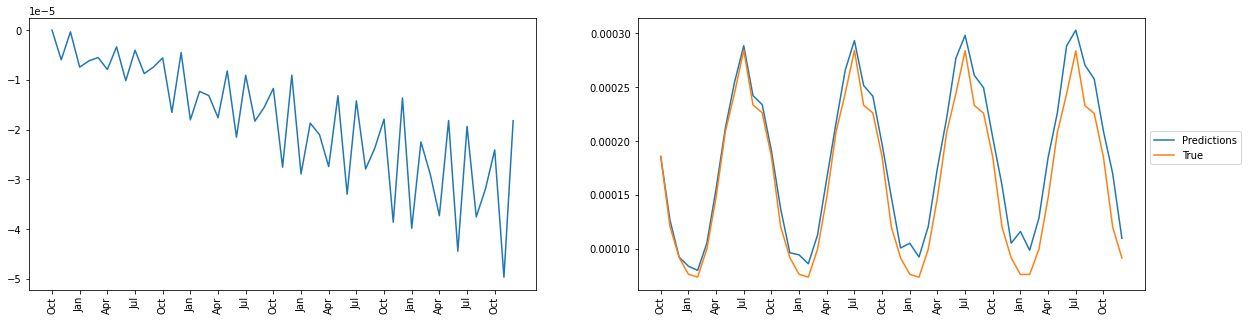

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

indices = np.arange(0, len(test_data), 3)
ticks = [date.strftime('%b') for date in test_data['ts'].index]
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0].plot(errors)

axs[1].plot(predictions, label='Predictions')
axs[1].plot(test_data['ts'].values, label='True')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[1].legend(loc='upper right', bbox_to_anchor=(1.2, 0.6))
plt.show()

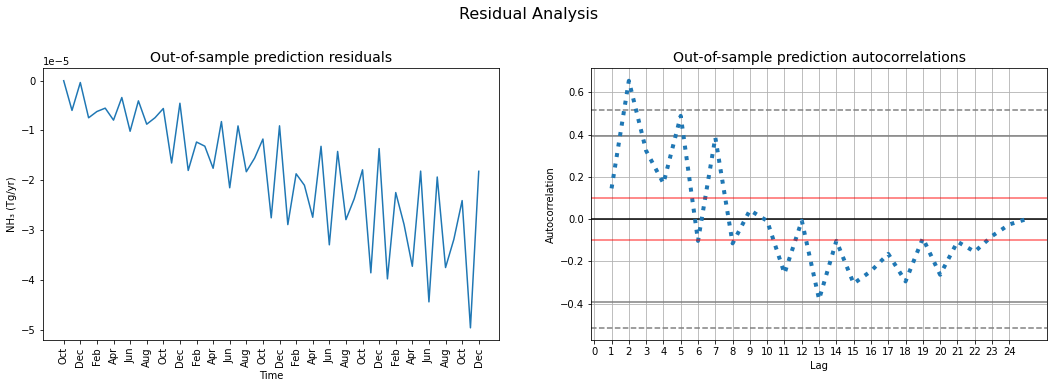

In [25]:
from pandas.plotting import autocorrelation_plot

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual Analysis', fontsize=16, y=1.05)

axs[0].plot(errors)
axs[0].set_title('Out-of-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

indices = np.arange(0, len(test_data), 2)
ticks = [date.strftime('%b') for date in test_data['ts'].index]
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

lags = 25
autocorrelation_plot(errors[:lags], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('Out-of-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

indices = np.arange(0, lags, 1)
axs[1].set_xticks(indices)
axs[1].set_xticklabels(indices)

plt.show()

## In-sample predictions

In [26]:
from pandas.plotting import autocorrelation_plot

predictions = model.predict(start=train_data['ts'].index[12], end=train_data['ts'].index[-1])

errors = train_data['ts'][12:].values - predictions.values

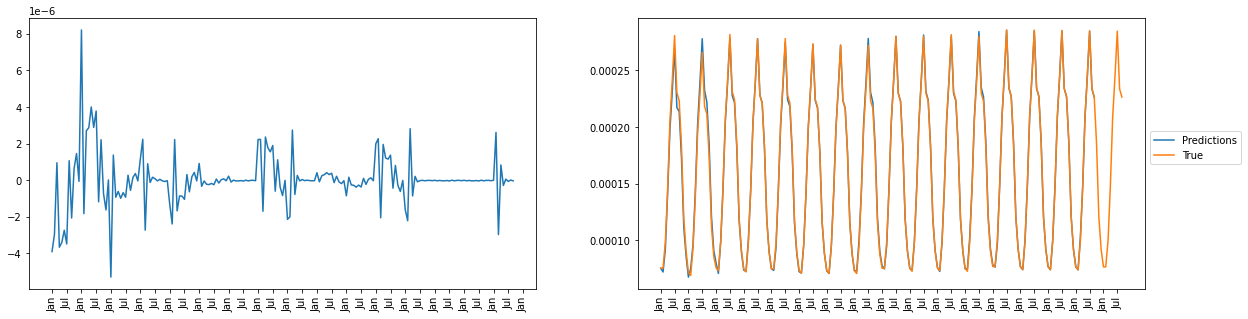

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

indices = np.arange(0, len(train_data), 6)
ticks = [date.strftime('%b') for date in train_data['ts'].index]

axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[0].plot(errors)

axs[1].plot(predictions.values, label='Predictions')
axs[1].plot(train_data['ts'].values, label='True')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)
axs[1].legend(loc='upper right', bbox_to_anchor=(1.2, 0.6))
plt.show()

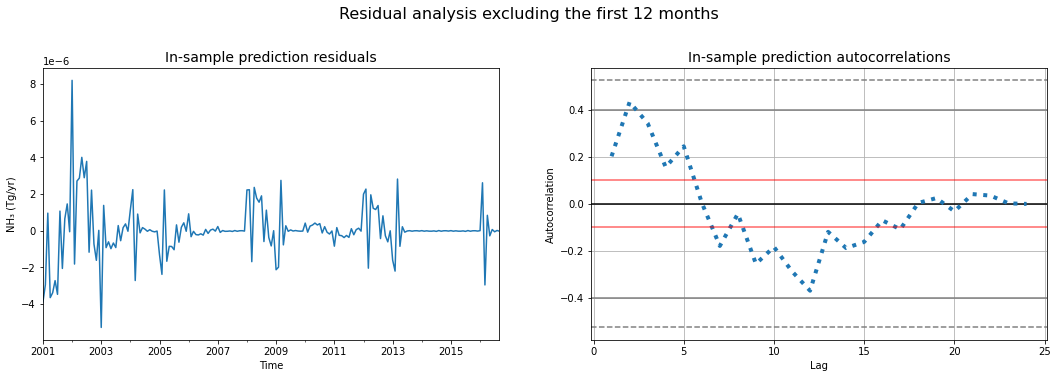

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
fig.suptitle('Residual analysis excluding the first 12 months', fontsize=16,  y=1.05)

pd.Series(errors, index=predictions.index).plot(ax=axs[0])
axs[0].plot(errors)
axs[0].set_title('In-sample prediction residuals', fontsize=14)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('NH3 (Tg/yr)'.translate(to_pedix))

autocorrelation_plot(errors[:24], ax=axs[1], linestyle='dotted', linewidth=4)
axs[1].set_title('In-sample prediction autocorrelations', fontsize=14)

axs[1].axhline(y=-0.1, color='r', linestyle='-', alpha=.6)
axs[1].axhline(y=0.1, color='r', linestyle='-', alpha=.6)

plt.show()